# Evolution of Einstein's equations

# Initial data constants definition

# Initial data , setting length of the domain and discretization


In [471]:
m=1;
res=m;
N=2.0^m*20.0;
Rf=1.0;

dx=Rf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m;
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 2.0


In [472]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2))

dx =0.025
dt =0.01
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2*3) = 0.625


In [473]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1"

In [474]:
println(dx)
println(dt)

0.025
0.01


In [475]:
epsilon=1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

1

# Grid

In [476]:
ori=0.0;
R1 = nothing
R1=range(ori, stop=Rf, step=dx);

print(size(R1))

(41,)

In [477]:
print(dx)
#R = range(ori-2.0*dx, stop=Rf+2.0*dx, step=dx);
R = range(round(ori-3.0*dx,digits=10), stop=Rf+3.0*dx, step=dx)

L=length(R);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf-dt,step=dt)
println("the time step is ", dt)
println(size(T))
println(size(R))

println(R[L-3])
println(L)

0.025step size is  0.025
the time step is 0.01
(200,)
(47,)
1.0
47


In [478]:
include("./ScalarField.jl");

In [479]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [480]:
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initpsibar=zeros(L);
state_array=[initm initbeta initpsi initpsibar];



#PSI BAR

#psibar0=1
c=0.35
sigma=0.1
Amp=0.05
"c=0.35*40
sigma=0.1*40
Amp=0.05*40"
initpsibar[4:L-3] = scalar_spaceder(R1)
state_array[:,4]=initpsibar;
state_array=ghost(state_array);

#PSI FROM PSI,X
interp = cubic_spline_interpolation(R[4:L-3], state_array[4:L-3,4],  extrapolation_bc = Line())
psi0=0
SFconstraint_psi_new(psi0,R1) = interp.(R1)
initpsi = rungekutta4(SFconstraint_psi_new,psi0,R)
state_array[:,3]=initpsi;
state_array=ghost(state_array);

#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,R1,0)
state_array[:,2]=initbeta;

#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,R1,0)
state_array[:,1]=initm;
state_array=ghost(state_array);

R=0!!!R=0!!!

# Defining the initial state array for the evolution m β Ψ and Ψ,x

just debugging

In [481]:
"int(x) = floor(Int, x)
print(int.([0.2 1.9]))

a=R1/dx
println(a[3])
println((R1/dx)[3])
println(state_array[int((R1/dx)[1])+1,4])
println(state_array[int((R1[1]/dx+1)),4])
println(state_array[1,4])

println(state_array[int.(R1./dx.+1),4])
println(state_array[:,4])"

"int(x) = floor(Int, x)\nprint(int.([0.2 1.9]))\n\na=R1/dx\nprintln(a[3])\nprintln((R1/dx)[3])\nprintln(state_array[int((R1/dx)[1])+1,4])\nprintln(state_array[int((R1[1]/dx+1)),4])\nprintln(state_array[1,4])\n\nprintln(state_array[int.(R1./dx.+1),4])\nprintln(state_array[:,4])"

In [482]:
using CSV, Tables
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

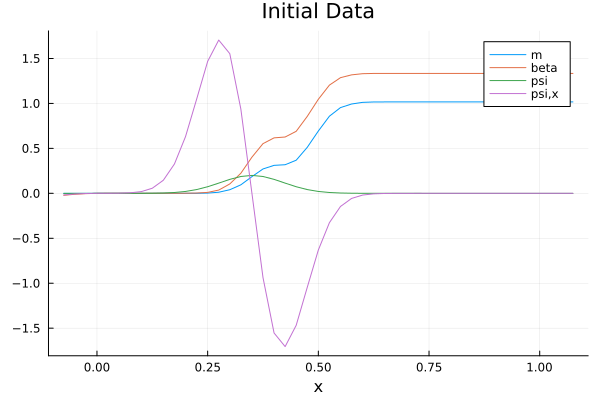

In [483]:
using Plots #showing initial data and the initial status of the horizon finder
plot(R, state_array, xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])

 ## Time evolution

In [484]:
using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T/10)
    
    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0) #evolve psi,x
    state_array=ghost(state_array)
    
    #calculate psi from psi,x
    interp = cubic_spline_interpolation(R[4:L-3], state_array[4:L-3,4],  extrapolation_bc = Line())

    psi0=0
    SFconstraint_psi_new(psi0,R1) = interp.(R1)

    state_array[:,3] = rungekutta4(SFconstraint_psi_new,psi0,R)
    state_array=ghost(state_array)
    
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=rk4wrapper(SFconstraint_m,m0,R1,T)
    
    state_array=ghost(state_array)
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,R1,T)
    
    state_array=ghost(state_array)
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end

R=0!!!R=0!!!

Progress:   1%|▍                                        |  ETA: 0:01:39

R=0!!!R=0!!!

Progress:   2%|▋                                        |  ETA: 0:01:19

R=0!!!R=0!!!

Progress:   2%|▉                                        |  ETA: 0:01:07

R=0!!!R=0!!!

Progress:   2%|█                                        |  ETA: 0:01:00

R=0!!!R=0!!!

Progress:   3%|█▎                                       |  ETA: 0:00:56

R=0!!!R=0!!!

Progress:   4%|█▍                                       |  ETA: 0:00:53

R=0!!!R=0!!!

Progress:   4%|█▋                                       |  ETA: 0:00:50

R=0!!!R=0!!!

Progress:   4%|█▉                                       |  ETA: 0:00:49

R=0!!!R=0!!!

Progress:   5%|██                                       |  ETA: 0:00:47

R=0!!!R=0!!!

Progress:   6%|██▎                                      |  ETA: 0:00:45

R=0!!!R=0!!!

Progress:   6%|██▌                                      |  ETA: 0:00:44

R=0!!!R=0!!!

Progress:   6%|██▋                                      |  ETA: 0:00:43

R=0!!!R=0!!!

Progress:   7%|██▉                                      |  ETA: 0:00:42

R=0!!!R=0!!!

Progress:   8%|███▏                                     |  ETA: 0:00:41

R=0!!!R=0!!!

Progress:   8%|███▎                                     |  ETA: 0:00:40

R=0!!!R=0!!!

Progress:   8%|███▌                                     |  ETA: 0:00:39

R=0!!!R=0!!!

Progress:   9%|███▊                                     |  ETA: 0:00:39

R=0!!!R=0!!!

Progress:  10%|███▉                                     |  ETA: 0:00:38

R=0!!!R=0!!!

Progress:  10%|████▏                                    |  ETA: 0:00:37

R=0!!!R=0!!!

Progress:  10%|████▎                                    |  ETA: 0:00:37

R=0!!!R=0!!!

Progress:  11%|████▌                                    |  ETA: 0:00:36

R=0!!!R=0!!!

Progress:  12%|████▊                                    |  ETA: 0:00:36

R=0!!!R=0!!!

Progress:  12%|████▉                                    |  ETA: 0:00:36

R=0!!!R=0!!!

Progress:  12%|█████▏                                   |  ETA: 0:00:35

R=0!!!R=0!!!

Progress:  13%|█████▍                                   |  ETA: 0:00:35

R=0!!!R=0!!!

Progress:  14%|█████▌                                   |  ETA: 0:00:34

R=0!!!R=0!!!

Progress:  14%|█████▊                                   |  ETA: 0:00:34

R=0!!!R=0!!!

Progress:  14%|██████                                   |  ETA: 0:00:34

R=0!!!R=0!!!

Progress:  15%|██████▏                                  |  ETA: 0:00:33

R=0!!!R=0!!!

Progress:  16%|██████▍                                  |  ETA: 0:00:33

R=0!!!R=0!!!

Progress:  16%|██████▌                                  |  ETA: 0:00:33

R=0!!!R=0!!!

Progress:  16%|██████▊                                  |  ETA: 0:00:32

R=0!!!R=0!!!

Progress:  17%|███████                                  |  ETA: 0:00:32

R=0!!!R=0!!!

Progress:  18%|███████▏                                 |  ETA: 0:00:32

R=0!!!R=0!!!

Progress:  18%|███████▍                                 |  ETA: 0:00:31

R=0!!!R=0!!!

Progress:  18%|███████▋                                 |  ETA: 0:00:31

R=0!!!R=0!!!

Progress:  19%|███████▊                                 |  ETA: 0:00:31

R=0!!!R=0!!!

Progress:  20%|████████                                 |  ETA: 0:00:30

R=0!!!R=0!!!

Progress:  20%|████████▎                                |  ETA: 0:00:30

R=0!!!R=0!!!

Progress:  20%|████████▍                                |  ETA: 0:00:30

R=0!!!R=0!!!

Progress:  21%|████████▋                                |  ETA: 0:00:30

R=0!!!R=0!!!

Progress:  22%|████████▉                                |  ETA: 0:00:29

R=0!!!R=0!!!

Progress:  22%|█████████                                |  ETA: 0:00:29

R=0!!!R=0!!!

Progress:  22%|█████████▎                               |  ETA: 0:00:29

R=0!!!R=0!!!

Progress:  23%|█████████▍                               |  ETA: 0:00:29

R=0!!!R=0!!!

Progress:  24%|█████████▋                               |  ETA: 0:00:28

R=0!!!R=0!!!

Progress:  24%|█████████▉                               |  ETA: 0:00:28

R=0!!!R=0!!!

Progress:  24%|██████████                               |  ETA: 0:00:28

R=0!!!R=0!!!

Progress:  25%|██████████▎                              |  ETA: 0:00:28

R=0!!!R=0!!!

Progress:  26%|██████████▌                              |  ETA: 0:00:27

R=0!!!R=0!!!

Progress:  26%|██████████▋                              |  ETA: 0:00:27

R=0!!!R=0!!!

Progress:  26%|██████████▉                              |  ETA: 0:00:27

R=0!!!R=0!!!

Progress:  27%|███████████▏                             |  ETA: 0:00:27

R=0!!!R=0!!!

Progress:  28%|███████████▎                             |  ETA: 0:00:26

R=0!!!R=0!!!

Progress:  28%|███████████▌                             |  ETA: 0:00:26

R=0!!!R=0!!!

Progress:  28%|███████████▋                             |  ETA: 0:00:26

R=0!!!R=0!!!

Progress:  29%|███████████▉                             |  ETA: 0:00:26

R=0!!!R=0!!!

Progress:  30%|████████████▏                            |  ETA: 0:00:25

R=0!!!R=0!!!

Progress:  30%|████████████▎                            |  ETA: 0:00:25

R=0!!!R=0!!!

Progress:  30%|████████████▌                            |  ETA: 0:00:25

R=0!!!R=0!!!

Progress:  31%|████████████▊                            |  ETA: 0:00:25

R=0!!!R=0!!!

Progress:  32%|████████████▉                            |  ETA: 0:00:25

R=0!!!R=0!!!

Progress:  32%|█████████████▏                           |  ETA: 0:00:24

R=0!!!R=0!!!

Progress:  32%|█████████████▍                           |  ETA: 0:00:24

R=0!!!R=0!!!

Progress:  33%|█████████████▌                           |  ETA: 0:00:24

R=0!!!R=0!!!

Progress:  34%|█████████████▊                           |  ETA: 0:00:24

R=0!!!R=0!!!

Progress:  34%|██████████████                           |  ETA: 0:00:23

R=0!!!R=0!!!

Progress:  34%|██████████████▏                          |  ETA: 0:00:23

R=0!!!R=0!!!

Progress:  35%|██████████████▍                          |  ETA: 0:00:23

R=0!!!R=0!!!

Progress:  36%|██████████████▌                          |  ETA: 0:00:23

R=0!!!R=0!!!

Progress:  36%|██████████████▊                          |  ETA: 0:00:23

R=0!!!R=0!!!

Progress:  36%|███████████████                          |  ETA: 0:00:22

R=0!!!R=0!!!

Progress:  37%|███████████████▏                         |  ETA: 0:00:22

R=0!!!R=0!!!

Progress:  38%|███████████████▍                         |  ETA: 0:00:22

R=0!!!R=0!!!

Progress:  38%|███████████████▋                         |  ETA: 0:00:22

R=0!!!R=0!!!

Progress:  38%|███████████████▊                         |  ETA: 0:00:22

R=0!!!R=0!!!

Progress:  39%|████████████████                         |  ETA: 0:00:21

R=0!!!R=0!!!

Progress:  40%|████████████████▎                        |  ETA: 0:00:21

R=0!!!R=0!!!

Progress:  40%|████████████████▍                        |  ETA: 0:00:21

R=0!!!R=0!!!

Progress:  40%|████████████████▋                        |  ETA: 0:00:21

R=0!!!R=0!!!

Progress:  41%|████████████████▊                        |  ETA: 0:00:21

R=0!!!R=0!!!

Progress:  42%|█████████████████                        |  ETA: 0:00:21

R=0!!!R=0!!!

Progress:  42%|█████████████████▎                       |  ETA: 0:00:20

R=0!!!R=0!!!

Progress:  42%|█████████████████▍                       |  ETA: 0:00:20

R=0!!!R=0!!!

Progress:  43%|█████████████████▋                       |  ETA: 0:00:20

R=0!!!R=0!!!

Progress:  44%|█████████████████▉                       |  ETA: 0:00:20

R=0!!!R=0!!!

Progress:  44%|██████████████████                       |  ETA: 0:00:20

R=0!!!R=0!!!

Progress:  44%|██████████████████▎                      |  ETA: 0:00:19

R=0!!!R=0!!!

Progress:  45%|██████████████████▌                      |  ETA: 0:00:19

R=0!!!R=0!!!

Progress:  46%|██████████████████▋                      |  ETA: 0:00:19

R=0!!!R=0!!!

Progress:  46%|██████████████████▉                      |  ETA: 0:00:19

R=0!!!R=0!!!

Progress:  46%|███████████████████▏                     |  ETA: 0:00:19

R=0!!!R=0!!!

Progress:  47%|███████████████████▎                     |  ETA: 0:00:18

R=0!!!R=0!!!

Progress:  48%|███████████████████▌                     |  ETA: 0:00:18

R=0!!!R=0!!!

Progress:  48%|███████████████████▋                     |  ETA: 0:00:18

R=0!!!R=0!!!

Progress:  48%|███████████████████▉                     |  ETA: 0:00:18

R=0!!!R=0!!!

Progress:  49%|████████████████████▏                    |  ETA: 0:00:18

R=0!!!R=0!!!

Progress:  50%|████████████████████▎                    |  ETA: 0:00:18

R=0!!!R=0!!!

Progress:  50%|████████████████████▌                    |  ETA: 0:00:17

R=0!!!R=0!!!

Progress:  50%|████████████████████▊                    |  ETA: 0:00:17

R=0!!!R=0!!!

Progress:  51%|████████████████████▉                    |  ETA: 0:00:17

R=0!!!R=0!!!

Progress:  52%|█████████████████████▏                   |  ETA: 0:00:17

R=0!!!R=0!!!

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:17

R=0!!!R=0!!!

Progress:  52%|█████████████████████▌                   |  ETA: 0:00:17

R=0!!!R=0!!!

Progress:  53%|█████████████████████▊                   |  ETA: 0:00:16

R=0!!!R=0!!!

Progress:  54%|█████████████████████▉                   |  ETA: 0:00:16

R=0!!!R=0!!!

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:16

R=0!!!R=0!!!

Progress:  54%|██████████████████████▍                  |  ETA: 0:00:16

R=0!!!R=0!!!

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:16

R=0!!!R=0!!!

Progress:  56%|██████████████████████▊                  |  ETA: 0:00:16

R=0!!!R=0!!!

Progress:  56%|███████████████████████                  |  ETA: 0:00:15

R=0!!!R=0!!!

Progress:  56%|███████████████████████▏                 |  ETA: 0:00:15

R=0!!!R=0!!!

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:15

R=0!!!R=0!!!

Progress:  58%|███████████████████████▋                 |  ETA: 0:00:15

R=0!!!R=0!!!

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:15

R=0!!!R=0!!!

Progress:  58%|████████████████████████                 |  ETA: 0:00:14

R=0!!!R=0!!!

Progress:  59%|████████████████████████▎                |  ETA: 0:00:14

R=0!!!R=0!!!

Progress:  60%|████████████████████████▍                |  ETA: 0:00:14

R=0!!!R=0!!!

Progress:  60%|████████████████████████▋                |  ETA: 0:00:14

R=0!!!R=0!!!

Progress:  60%|████████████████████████▊                |  ETA: 0:00:14

R=0!!!R=0!!!

Progress:  61%|█████████████████████████                |  ETA: 0:00:14

R=0!!!R=0!!!

Progress:  62%|█████████████████████████▎               |  ETA: 0:00:13

R=0!!!R=0!!!

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:13

R=0!!!R=0!!!

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:13

R=0!!!R=0!!!

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:13

R=0!!!R=0!!!

Progress:  64%|██████████████████████████               |  ETA: 0:00:13

R=0!!!R=0!!!

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:13

R=0!!!R=0!!!

Progress:  64%|██████████████████████████▌              |  ETA: 0:00:12

R=0!!!R=0!!!

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:12

R=0!!!R=0!!!

Progress:  66%|██████████████████████████▉              |  ETA: 0:00:12

R=0!!!R=0!!!

Progress:  66%|███████████████████████████              |  ETA: 0:00:12

R=0!!!R=0!!!

Progress:  66%|███████████████████████████▎             |  ETA: 0:00:12

R=0!!!R=0!!!

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:11

R=0!!!R=0!!!

Progress:  68%|███████████████████████████▋             |  ETA: 0:00:11

R=0!!!R=0!!!

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:11

R=0!!!R=0!!!

Progress:  68%|████████████████████████████▏            |  ETA: 0:00:11

R=0!!!R=0!!!

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:11

R=0!!!R=0!!!

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:11

R=0!!!R=0!!!

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:10

R=0!!!R=0!!!

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:10

R=0!!!R=0!!!

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:10

R=0!!!R=0!!!

Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:10

R=0!!!R=0!!!

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:10

R=0!!!R=0!!!

Progress:  72%|█████████████████████████████▊           |  ETA: 0:00:10

R=0!!!R=0!!!

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:09

R=0!!!R=0!!!

Progress:  74%|██████████████████████████████▏          |  ETA: 0:00:09

R=0!!!R=0!!!

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:09

R=0!!!R=0!!!

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:09

R=0!!!R=0!!!

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:09

R=0!!!R=0!!!

Progress:  76%|███████████████████████████████          |  ETA: 0:00:08

R=0!!!R=0!!!

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:08

R=0!!!R=0!!!

Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:08

R=0!!!R=0!!!

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:08

R=0!!!R=0!!!

Progress:  78%|███████████████████████████████▊         |  ETA: 0:00:08

R=0!!!R=0!!!

Progress:  78%|████████████████████████████████         |  ETA: 0:00:08

R=0!!!R=0!!!

Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:07

R=0!!!R=0!!!

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:07

R=0!!!R=0!!!

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:07

R=0!!!R=0!!!

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:07

R=0!!!R=0!!!

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:07

R=0!!!R=0!!!

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:07

R=0!!!R=0!!!

Progress:  82%|█████████████████████████████████▍       |  ETA: 0:00:06

R=0!!!R=0!!!

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:06

R=0!!!R=0!!!

Progress:  82%|█████████████████████████████████▉       |  ETA: 0:00:06

R=0!!!R=0!!!

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:06

R=0!!!R=0!!!

Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:06

R=0!!!R=0!!!

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:06

R=0!!!R=0!!!

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:05

R=0!!!R=0!!!

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:05

R=0!!!R=0!!!

Progress:  86%|███████████████████████████████████      |  ETA: 0:00:05

R=0!!!R=0!!!

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:05

R=0!!!R=0!!!

Progress:  86%|███████████████████████████████████▌     |  ETA: 0:00:05

R=0!!!R=0!!!

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:04

R=0!!!R=0!!!

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:04

R=0!!!R=0!!!

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:04

R=0!!!R=0!!!

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:04

R=0!!!R=0!!!

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:04

R=0!!!R=0!!!

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:04

R=0!!!R=0!!!

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:03

R=0!!!R=0!!!

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:03

R=0!!!R=0!!!

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:03

R=0!!!R=0!!!

Progress:  92%|█████████████████████████████████████▌   |  ETA: 0:00:03

R=0!!!R=0!!!

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:03

R=0!!!R=0!!!

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:03

R=0!!!R=0!!!

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:02

R=0!!!R=0!!!

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:02

R=0!!!R=0!!!

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:02

R=0!!!R=0!!!

Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:02

R=0!!!R=0!!!

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:02

R=0!!!R=0!!!

Progress:  96%|███████████████████████████████████████▏ |  ETA: 0:00:02

R=0!!!R=0!!!

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

R=0!!!R=0!!!

Progress:  96%|███████████████████████████████████████▋ |  ETA: 0:00:01

R=0!!!R=0!!!

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:01

R=0!!!R=0!!!

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:01

R=0!!!R=0!!!

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

R=0!!!R=0!!!

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

R=0!!!R=0!!!

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

R=0!!!R=0!!!

Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

R=0!!!R=0!!!

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


R=0!!!R=0!!!

In [485]:
print(dir)

/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1

In [486]:
"check boxh expression"

"check boxh expression"

## Movie of the evolution

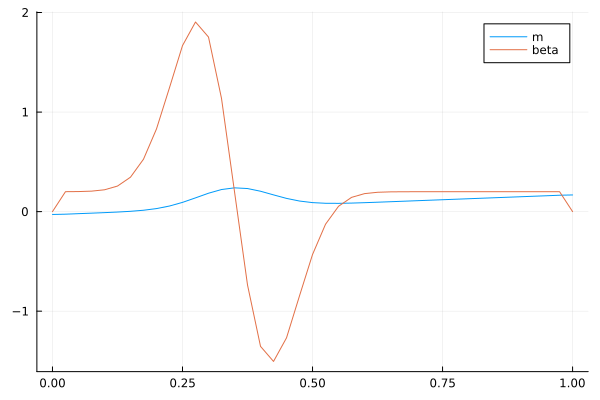

In [490]:
using Plots, CSV, DataFrames
import GR
for n in 1:1:10#length(T/10)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
    d=round(T[n],digits=1)
    plot!(R1, [plot3 plot4], labels=["m" "beta"]) |> display 
    
    end

# Interpolation

In [77]:
N=3
x=zeros(N);
y=zeros(N);

x=[1.1, 2.8, 4.7]
x1=[1.1, 2.8, 4.8]
y=[1.5, 4.3, 16.1]

data=[x y];


using Interpolations
data[:,1]=x
data[:,2]=y
itp = cubic_spline_interpolation(10:12, 10:12,  extrapolation_bc = Line()) # create interpolation function
itp(9) # call function on input data (use itp.(x) to broadcast over input vector)

8.999999999999998

In [78]:
itp.([9, 8, 1])

3-element Vector{Float64}:
 8.999999999999998
 7.9999999999999964
 0.999999999999984

In [79]:
itp2 = cubic_spline_interpolation(R[4:L-3], state_array[4:L-3,4],  extrapolation_bc = Line())
itp2.(R)

207-element Vector{Float64}:
 -2.2492802065157096e-5
 -1.49952013767714e-5
 -7.4976006883857e-6
 -4.235164736271502e-22
  7.689629700730104e-6
  1.6552824829107725e-5
  2.7892775217897982e-5
  4.327954001763802e-5
  6.470230120446899e-5
  9.474349404271483e-5
  0.00013678076996669706
  0.00019522129280422345
  0.0002757706956599848
  ⋮
 -2.01566457731864e-39
 -5.719520396176462e-40
 -1.6084935678107224e-40
 -4.483299003815029e-41
 -1.238497196306582e-41
 -3.3908734463825724e-42
 -9.201267173992415e-43
 -2.4745912801619788e-43
 -6.595980413957055e-44
  4.924866297391118e-44
  1.644571300873888e-43
  2.7966559720087055e-43

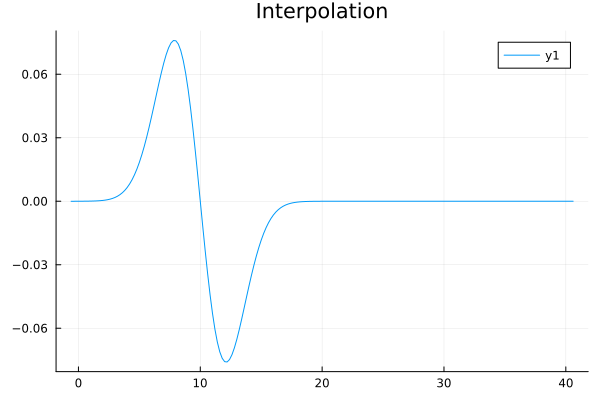

In [80]:
using Plots #showing initial data and the initial status of the horizon finder
plot(R, itp2.(R),title="Interpolation")

In [81]:
psi0=0
SFconstraint_psi_new(psi0,R1) = itp2.(R1)

integration = rungekutta4(SFconstraint_psi_new,psi0,R1)

201-element Vector{Float64}:
  0.0
  7.593615194557902e-7
  3.153733052908858e-6
  7.544874151946501e-6
  1.4579476734114407e-5
  2.5257454987628783e-5
  4.103276552659288e-5
  6.395174800239e-5
  9.683503246584859e-5
  0.00014350975614535846
  0.00020909900645941614
  0.0003003748605932674
  0.00042617989754202296
  ⋮
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6
 -7.949465316117314e-6

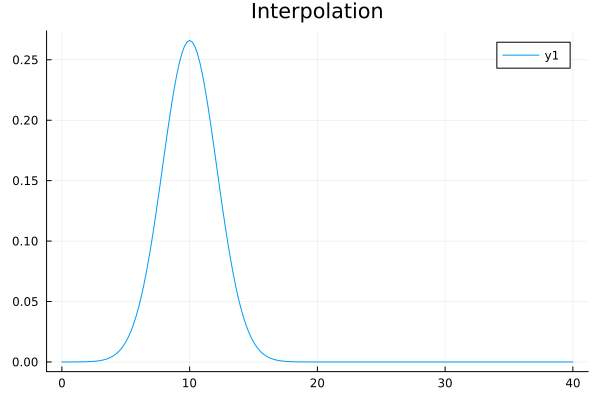

In [82]:
using Plots #showing initial data and the initial status of the horizon finder
plot(R1, integration,title="Interpolation")